# 04_Modeling_Forecasting

##### Imports & Config

In [1]:
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.set_option("display.max_columns", 100)


##### Load Feature Dataset

In [2]:
df = pd.read_parquet(
    "data/cleaned/yellow_taxi_features_hourly_zone_2025.parquet"
)

df = df.sort_values("pickup_hour_ts")
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1266674 entries, 616348 to 497638
Data columns (total 23 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   PULocationID         1266674 non-null  int32         
 1   pickup_hour_ts       1266674 non-null  datetime64[us]
 2   demand               1266674 non-null  int64         
 3   avg_fare             1266674 non-null  float64       
 4   avg_trip_distance    1266674 non-null  float64       
 5   avg_passenger_count  1266674 non-null  float64       
 6   hour                 1266674 non-null  int8          
 7   weekday              1266674 non-null  int8          
 8   month                1266674 non-null  int8          
 9   is_weekend           1266674 non-null  int8          
 10  is_rush_hour         1266674 non-null  int8          
 11  hour_sin             1266674 non-null  float64       
 12  hour_cos             1266674 non-null  float64       
 13

##### Define Target & Features

In [3]:
TARGET = "demand"

DROP_COLS = [
    "pickup_hour_ts",
]

FEATURES = [c for c in df.columns if c not in DROP_COLS + [TARGET]]

X = df[FEATURES]
y = df[TARGET]


##### Time-based Train / Test Split

In [4]:
split_date = df["pickup_hour_ts"].quantile(0.8)

train_idx = df["pickup_hour_ts"] <= split_date
test_idx  = df["pickup_hour_ts"] > split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)


Train size: (1013468, 21)
Test size : (253206, 21)


##### Baseline Model (Naive)

In [6]:
baseline_pred = X_test["demand_lag_1"]

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"Baseline MAE : {baseline_mae:,.2f}")
print(f"Baseline RMSE: {baseline_rmse:,.2f}")


Baseline MAE : 8.80
Baseline RMSE: 21.89


##### Train LightGBM Model

In [7]:
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2864
[LightGBM] [Info] Number of data points in the train set: 1013468, number of used features: 20
[LightGBM] [Info] Start training from score 32.739942


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


##### Model Evaluation

In [8]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"LightGBM MAE : {mae:,.2f}")
print(f"LightGBM RMSE: {rmse:,.2f}")
print(f"LightGBM MAPE: {mape:.2f}%")


LightGBM MAE : 5.34
LightGBM RMSE: 12.51
LightGBM MAPE: 45.80%


##### Improvement vs Baseline

In [9]:
print(
    f"MAE Improvement: "
    f"{(baseline_mae - mae) / baseline_mae * 100:.2f}%"
)


MAE Improvement: 39.30%


##### Feature Importance

In [10]:
import matplotlib.pyplot as plt

importances = (
    pd.DataFrame({
        "feature": FEATURES,
        "importance": model.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

importances.head(15)


,feature,importance
14,demand_lag_1,3235
0,PULocationID,2937
17,demand_lag_24,2695
4,hour,2558
3,avg_passenger_count,2159
1,avg_fare,1946
2,avg_trip_distance,1918
20,demand_roll_mean_24,1832
16,demand_lag_3,1646
15,demand_lag_2,1623


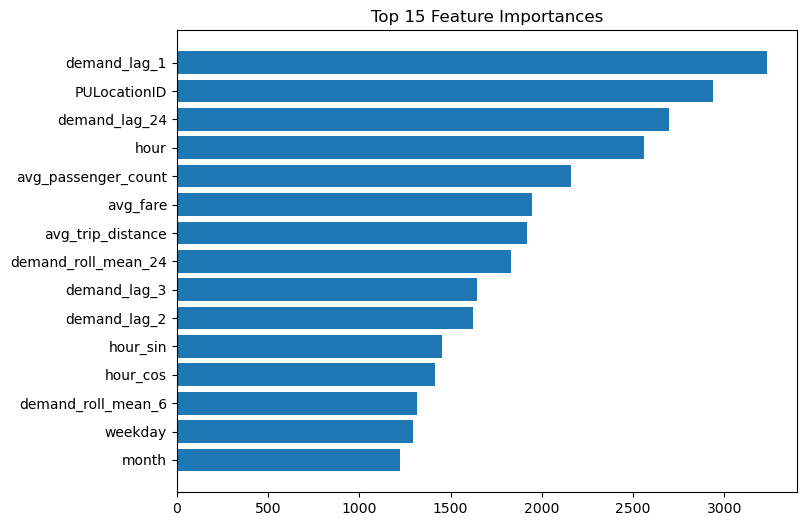

In [11]:
plt.figure(figsize=(8,6))
plt.barh(
    importances["feature"].head(15)[::-1],
    importances["importance"].head(15)[::-1]
)
plt.title("Top 15 Feature Importances")
plt.show()


##### Save Model

In [13]:
import joblib

joblib.dump(
    model,
    "outputs/models/lightgbm_hourly_zone_demand.pkl"
)


['outputs/models/lightgbm_hourly_zone_demand.pkl']